In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [6]:
# define data
charge_eu = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_eu.csv", encoding='utf-8-sig')
charge_na = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_na.csv", encoding='utf-8-sig')
purchase_eu = pd.read_csv("D:\creditCardFraudDetection_data/20170411_purchase_eu.csv", encoding='utf-8-sig')
purchase_na = pd.read_csv("D:\creditCardFraudDetection_data/20170411_purchase_eu.csv", encoding='utf-8-sig')

In [52]:
# charge_status가 60. 65인 user는 환불 유저로써 class는 1, 아니면 0
def createNewTypeDataSet(data_set, isAbuser):
    if isAbuser == 1:
        data_set = data_set[data_set.charge_status >= 60].drop_duplicates(['user_no'], keep='last')
    else:
        data_set = data_set[data_set.charge_status < 60].drop_duplicates(['user_no'], keep='last')
        
    data_set = pd.DataFrame(data_set, columns=['user_no'])
    data_set['Class'] = isAbuser
    return data_set

Percentage of normal user:  0.9954531902206321
Percentage of chargeback user:  0.004546809779367919


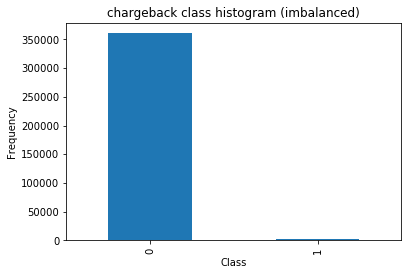

In [58]:
# 데이터 통합 및 일반 유저와 환불 유저의 비율
charge_eu_abuser = createNewTypeDataSet(charge_eu, 1)
charge_eu_normal = createNewTypeDataSet(charge_eu, 0)
charge_na_abuser = createNewTypeDataSet(charge_na, 1)
charge_na_normal = createNewTypeDataSet(charge_na, 0)
charge_all = pd.concat([charge_eu_abuser, charge_eu_normal, charge_na_abuser, charge_na_normal])
print("Percentage of normal user: ", len(charge_all[charge_all.Class == 0]) / len(charge_all))
print("Percentage of chargeback user: ", len(charge_all[charge_all.Class == 1]) / len(charge_all))
count_classes = pd.value_counts(charge_all['Class'], sort=True)
count_classes.plot(kind = 'bar')
plt.title("chargeback class histogram (imbalanced)")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [55]:
# feature 생성 과정
